# Example 1: MAX-CUT with the CIM

This notebook serves as an introduction to utilizing the coherent Ising machine for MAX-CUT problems. The key goals are as follows:

* Brute force solving a simple MAX-CUT problem
* Solving a MAX-CUT problem with our CIM simulator
* Showcasing spin and energy evolutions of the CIM simulator.

The physical realization of the coherent Ising machine is a computing system that consists of numerous coupled optical parametric oscillators with increasing gain that aims to find the minimum energy of some Ising problem. 

Due to physical constraints, we simulate our CIM in Python to model its performance. This means that we attempt to compute the minimum of the energy function 

$$ H = -\sum_{1\leq i \leq j \leq N} J_{ij}\sigma_i \sigma_j - \sum_{1 \leq i \leq N} h_i \sigma_i$$

where we have an $N \times N$ matrix for $J$ (which is our spin coupling matrix) and an $N$-dimensional vector $h$ (which serves as our external field terms), along with each spin $\sigma_i \in \{ -1, 1\}$.  This means to leverage the CIM on some optimization problem requires converting it into an Ising problem where the solution to the problem is correlated with the ground state energy of the problem in Ising form. 

We provide three implementations of the CIM: chaotic amplitude control (CAC), amplitude-heterogeneity correction (AHC), and amplitude-heterogeneity correction with external field terms (AHC). The first two solvers do not have an external field, while the latter requires an external field $h$.

When the MAX-CUT problem is reformatted into an Ising problem, there is no external field, so either the CAC solver or the AHC no external field solver can be used. 

## Loading J matrix

The coupling matrices and bias vectors are stored as Numpy arrays, which could be loaded in from delimited files via the helper function load_matrix_from_rudy(), or from npz files.


In [3]:
# in order to print out all outputs in arrays globally 
#np.set_printoptions(threshold=np.inf)
#np.set_printoptions(threshold = False) # to set back to truncated outputs

In [1]:
#Initialization and Imports
import sys 
sys.path.append(r'C:\yanxia\TU Dresden\NES\WHK\cim_optimizer\cim_optimizer')  # local path must be appended 
from solve_Ising import *
import AHC, AHC_tuning, extAHC, extAHC_tuning, CAC, CAC_tuning, CIM_helper
from CIM_helper import brute_force
import numpy as np

from pathlib import Path
sys.path.append(str(Path.cwd()) + "\\..\\") # append repo to list of search directories
print(Path.cwd())






%matplotlib inline

C:\yanxia\TU Dresden\NES\WHK\cim_optimizer\notebooks


In [2]:
instance_path_str_MAXCUT = str(Path.cwd()) + "\\..\\instances\\MC_Instances_NPZ\\"

# 20 spin MAXCUT problem
N = 20
mc_id = 1 # select first example of 20 spin MAXCUT problem
J = - np.load(instance_path_str_MAXCUT + f"MC50_N={N}_{mc_id}.npz") # load J matrix for 50% density MAX-CUT problem
gamma = 0.010 # set gamma hyperparameter

Note that we only modify the gamma hyperparameter since the default value for gamma (which is meant for MIRP problems) is too low for convergence towards the ground state energy.

## Brute force solving

We test every single possible spin configuration $\big($ i.e. $2^{20}$ configurations since each spin $\sigma_i \in \{ -1, 1\} \big)$, and return a tuple containing an array of the minimum spin configuration and ground state energy (lowest energy achieved).

In [8]:
spins_ground, E_ground = brute_force(J)

print("The spin configuration in the ground state is {}".format(spins_ground))
print("The ground energy is {}".format(E_ground))

The spin configuration in the ground state is [-1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1  1  1 -1]
The ground energy is -29.0


## Solving with the coherent Ising machine

We now apply the CAC CIM model to our J matrix for a single trial with default hyperparameters (with the exception of gamma). Our code returns certain pertinent metadata, including the target Ising energy, best Ising energy found and the corresponding spin configuration, time elapsed, number of trials, and success probability across the trials.

Note that the default behaviour of `Ising().solve` is to attempt to optimize the hyperparameters initially, but we showcase the highly efficient single-run performance of the simulated coherent Ising machine. 

In [11]:
with np.printoptions(threshold=np.inf): # show not truncated outputs but only locally
    test = Ising(J).solve(cac_gamma=gamma, hyperparameters_randomtune = False)

No External Field Detected
Target Ising Energy: -inf.
Best Ising Energy Found: -29.0.
Corresponding Spin Configuration: [-1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1.
  1. -1.].
Time Elapsed: 19.21693253517151.
Number of Runs Completed: 1.


In [12]:
print("Time Elapsed: {} seconds".format(test.result.time))

Time Elapsed: 19.21693253517151 seconds


No External Field Detected
Target Ising Energy: -inf.
Best Ising Energy Found: -29.0.
Corresponding Spin Configuration: [-1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1.
  1. -1.].
Time Elapsed: 18.722559690475464.
Number of Runs Completed: 1.
Whether CAC is used: False
Energy Evolution: [[ -9.  -9.  -9. ... -29. -29. -29.]]
Spin Evolution: [[[-7.2956376e-05 -6.8763191e-05 -6.4874257e-05 ... -8.1612027e-01
   -8.1537879e-01 -8.1463933e-01]
  [-1.7204930e-04 -1.6394349e-04 -1.5630139e-04 ...  6.7276317e-01
    6.7223406e-01  6.7171067e-01]
  [ 1.2329716e-04  1.2378713e-04  1.2397552e-04 ... -7.6720899e-01
   -7.6696265e-01 -7.6671517e-01]
  ...
  [ 3.5670004e-04  3.4542763e-04  3.3444422e-04 ... -4.6853802e-01
   -4.6856621e-01 -4.6859986e-01]
  [-4.8471478e-04 -4.6099987e-04 -4.3847886e-04 ... -8.1749626e-02
   -8.2030974e-02 -8.2322903e-02]
  [-4.1975864e-04 -4.0289518e-04 -3.8678039e-04 ... -6.9912314e-01
   -6.9905901e-01 -6.9899029e-01]]]


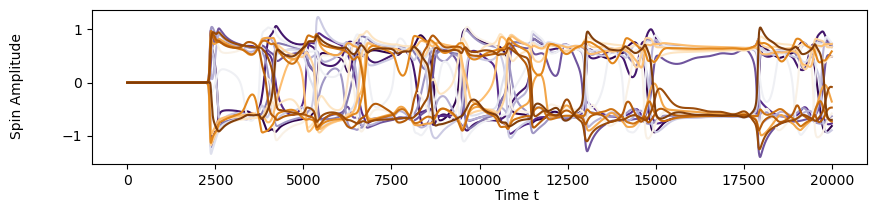

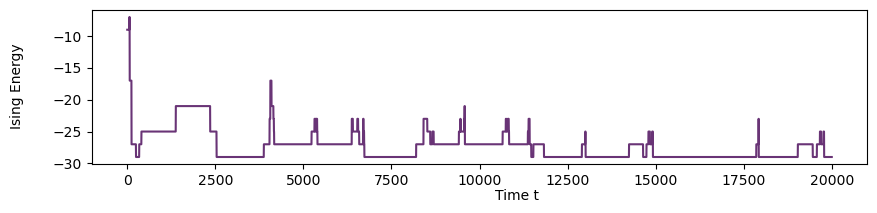

In [13]:
"""Note added by Yanxia: 
amplitude_control_scheme, optional Choice of amplitude control scheme to use, uses CAC for problems without external fields 
and AHC/CAC for problems with external fields by default. 
use_CAC : bool, default=True  (Option to select CAC or AHC solver for no external field.)
print(test.use_CAC) # True 
"extAHC.py and AHC.py contain implementations of amplitude-heterogeneity correction proposed by Leleu et al. with and without 
external fields, respectively. CAC.py contains the implementation of chaotic amplitude control proposed by Leleu et al. (which 
does not support external fields). The default hyperparameters for the CAC solver are set from the supplementary information 
found within the work listed here: (https://doi.org/10.1038/s42005-021-00768-0), while the default hyperparameters for the non-external 
field AHC solver are set from the supplementary information found within the work listed here: (https://doi.org/10.1103/PhysRevLett.122.040607)." 
Experiment, test2 use_CAC = False. """
test2 = Ising(J).solve(use_CAC = False, hyperparameters_randomtune = False)
print(f'Whether CAC is used: {test2.use_CAC}') # doesn't converge like CAC 

print("Energy Evolution: {}".format(test2.result.energy_evolution))
np.set_printoptions(threshold = False) # to set back to truncated outputs
print("Spin Evolution: {}".format(test2.result.spin_trajectories))
test2.result.plot_spin_trajectories(plot_type="spins")
test2.result.plot_spin_trajectories(plot_type="energy")

In [14]:
print("Time Elapsed: {} seconds".format(test2.result.time))

Time Elapsed: 18.722559690475464 seconds


## Metadata and internal dynamics of the CIM

Various properties of the solver runs can be read from the attributes of the run result object, such as the time elapsed, best Ising energy reached by the CIM, as  well as trajectories of the spin amplitudes over time. Similarly, the evolution of the Ising energy corresponding to the spin amplitudes over time could be plotted by specifying the argument plot_type="energy". 

If the solve() function was called with multiple runs, and specific runs among them need to be plotted, the argument trajectories_to_plot=[] takes in a list of the desired run indices.


In [16]:
print("Minimum Energy Achieved: {}".format(test.result.lowest_energy))

Minimum Energy Achieved: -29.0


In [17]:
np.set_printoptions(threshold=10, edgeitems=1)
print("Energy Evolution: {}".format(test.result.energy_evolution))
print("Spin Evolution: {}".format(test.result.spin_trajectories))


Energy Evolution: [[ 25. ... -29.]]
Spin Evolution: [[[ 7.6718279e-06 ... -1.0000000e+00]
  ...
  [-4.3335572e-04 ... -1.0000000e+00]]]


The internal dynamics of both the spin amplitudes and energy evolution are included to showcase how our CIM evolves over discrete time steps.

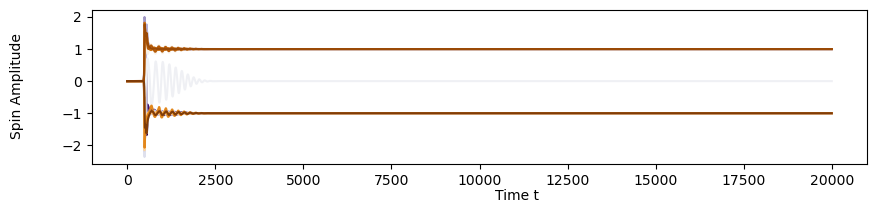

In [22]:
test.result.plot_spin_trajectories(plot_type="spins") # for t in range(T_time): T_time=1000 round trip time. So original two were plotted differently. 

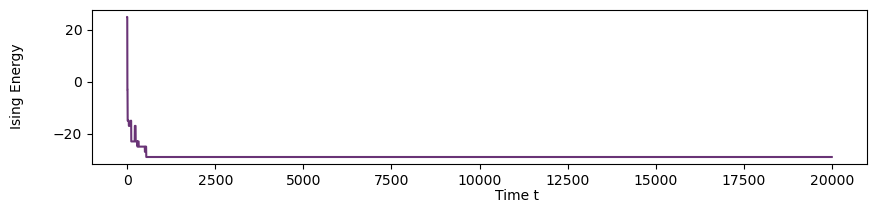

In [23]:
test.result.plot_spin_trajectories(plot_type="energy")

## GPU Acceleration

We now showcase our implementation with GPU acceleration using Pytorch and CUDA. While the speedup advantage is minor for smaller problems (such as an $N=20$ instance), the difference is more apparent at large spin counts. This is done by specifying the argument use_GPU=True, and requires a CUDA installation. By default, the argument use_GPU is set to False, and will run the solver in batches in parallel on the CPU.

In [ ]:
import torch

torch.cuda.is_available()


In [ ]:
test = Ising(J).solve(cac_gamma=gamma, use_GPU=True, hyperparameters_randomtune = False)

To specify the number of solver runs to be executed in parallel on a given device, the argument num_parallel_runs (set to 1 by default) can be modified. 

In [ ]:
test = Ising(J).solve(cac_gamma=gamma, use_GPU=True, num_runs=5, num_parallel_runs=5, hyperparameters_randomtune = False)

## Custom Ramp Schedules

The CIM-AHC, CIM-CAC solvers contain hyperparameters which could vary over the course of one solver run. To set an arbitrary feedback schedule, the arguments custom_feedback_schedule, custom_pump_schedule, and cac_amplitude_ramp can be specified with a specific anonymous function.

In [30]:
timestep_count = 1000
my_feedback_schedule = lambda x: np.sin(x/20)#torch.sin(torch.arange(timestep_count))
test = Ising(J).solve(cac_gamma=gamma, num_runs=5, num_timesteps_per_run = timestep_count, custom_feedback_schedule=my_feedback_schedule, hyperparameters_randomtune = False)


No External Field Detected
Target Ising Energy: -inf.
Best Ising Energy Found: -29.0.
Corresponding Spin Configuration: [-1. ... -1.].
Time Elapsed: 98.59586215019226.
Number of Runs Completed: 5.


## Setting a Target Energy

For benchmarking purposes, the ground-state Ising energy of inputted Ising problems can be specified to check whether the solver has reached it. This is modified via the target_energy argument.

In [33]:
timestep_count = 5000
ground_state_ising_energy = -29.0
my_feedback_schedule = lambda x: np.sin(x/33)
test = Ising(J).solve(cac_gamma=gamma, num_runs=5, target_energy=ground_state_ising_energy, num_timesteps_per_run = timestep_count, 
                      custom_feedback_schedule=my_feedback_schedule, hyperparameters_randomtune = False)

No External Field Detected
Target Ising Energy: -29.0.
Best Ising Energy Found: -29.0.
Corresponding Spin Configuration: [-1. ... -1.].
Time Elapsed: 496.8713164329529.
Number of Runs Completed: 5.
Success Probability: 1.0.


## Time Calculations for an optical Coherent Ising Machine

To translate this simulation into a realistic estimate of how much time this would take on a real FPGA-powered measurement-feedback Coherent Ising Machine, we multiply the number of matrix vector multiplications in our run by the roundtrip time reported in (https://doi.org/10.1126/science.aah5178)

In [36]:
print(f"Number of discrete steps (roundtrips): {timestep_count}")
roundtrip_time = 1.6e-6 #Roundtrip time in seconds, as reported in (https://doi.org/10.1126/science.aah5178)
print(f"Roundtrip time: {roundtrip_time} second")
print(f"Total CIM runtime: {timestep_count*roundtrip_time} second(s)")


Number of discrete steps (roundtrips): 5000
Roundtrip time: 1.6e-06 second
Total CIM runtime: 0.008 second(s)
